In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [14]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def retrieve_data(date, station='bik', quiet=[]):
    year = date[0:4]
    date = date[2:].replace('-','')
    file = f'{date}.{station}'
    #target_url = f'../data/210MM data/{year}/{station}/a5{file}'
    target_url = f'../data/210MM data/199610/a5{file}'
    line = []
    time = {'X':[], 'Y':[], 'Z':[]}
    magn = {'X':[], 'Y':[], 'Z':[]}

    try:
        data = open(target_url, 'r')
    except:
        print('no data', target_url)
        return pd.DataFrame([])

    print('retrieving data ...', date)
    for d in data:
        line = d.split()
        first = str(line[0])
        
        axis = first[-6]
        #valu = 0.1*np.array(line[3:], dtype=float)
        valu = 0.1*np.array([float(d[a:a+5]) for a in range(35,395,6)])
        yy = int(first[12:14]) + 1900
        mm = first[14:16]
        dd = first[16:18]
        hh = first[19:21]
        t = [f'{yy}-{mm}-{dd}T{hh}:{x:02d}' for x in range(60)]

        time[axis] = np.append(time[axis], t)
        magn[axis] = np.append(magn[axis], valu)
    
    dfx = pd.DataFrame({'time':time['X'], 'X':magn['X']})
    dfy = pd.DataFrame({'time':time['Y'], 'Y':magn['Y']})
    dfz = pd.DataFrame({'time':time['Z'], 'Z':magn['Z']})

    df = pd.merge(dfx, dfy, on='time', how='outer')
    df = pd.merge(df, dfz, on='time', how='outer')
    df['datetime'] = pd.to_datetime(df['time'])
    df['hour'] = [int(d[11:13]) for d in df['time']]
    df['min'] = [int(d[14:16]) for d in df['time']]
    df['day_fraction'] = (df['hour'] + df['min']/60.)/24.

    if len(quiet) > 0:
        df = calc_disturbance(df, quiet)
    return df

def find_quiet(date, qddays=None, range_=0):
    if (qddays is None):
        qddays = pd.read_csv('../data/QDDAYS.csv',
                             parse_dates=[0])
    if (range_ == 0):
        month = date[0:7]
        sel = qddays['month'] == month
    else:
        start = np.datetime64(date) - np.timedelta64(range_, 'D')
        end = np.datetime64(date) + np.timedelta64(range_, 'D')
        sel = np.logical_and((qddays['date'] >= start), (qddays['date'] <= end))

    selected = qddays[sel].copy().sort_values('rank').reset_index(drop=True)
    return selected
    
def retrieve_quiet(date, range_=0, station='bik', stat='mean'):
    qdays = find_quiet(date, range_=range_)
    quiet = pd.DataFrame()
    
    n = 0
    i = 0
    for i in range(len(qdays)):
        d = str(qdays['date'].values[i])[0:10]
        q = retrieve_data(d, station=station)
        if not(q is None):
            n += 1
            quiet = pd.concat([quiet, q], ignore_index=True)
        if n > 4:
            break
    
    if (len(quiet) < 1):
        return pd.DataFrame()
    avg = quiet.drop(columns=['time','datetime']).groupby(by='day_fraction').agg(stat)
    for c in ['X', 'Y', 'Z']:
        #avg[c] = moving_average(avg[c].values, n=5)
        avg[c] = avg[c].rolling(3).mean()
    avg = avg.reset_index()
    return avg

def calc_disturbance(raw, quiet):
    cols = ['day_fraction', 'X', 'Y', 'Z']
    merge = pd.merge(raw, quiet[cols], on='day_fraction', suffixes=('', '_q'))
    
    for c in ['X', 'Y', 'Z']:
        merge[c+'_d'] = merge[c] - merge[c+'_q']
        
    return merge

def calc_grad(df, suffix='_d'):
    dt = (df['datetime'].values[1:] - df['datetime'].values[:-1])
    dt = dt.astype(float)/6e10
    
    for c in ['X', 'Y', 'Z']:
        dx = df['X'+suffix].values[1:] - df['X'+suffix].values[:-1]
        dx = np.append(dx/dt, np.nan)
        df['d'+c] = dx
    
    return df


In [9]:
stations = pd.read_csv('../data/210mm_stations.csv')
stations = stations[stations.avail]
abbrev = [a.lower() for a in stations.Abbrev]

In [16]:
### UBAH TANGGAL ###

date = '1996-10-23'
short = date[2:].replace('-','')

rec = pd.DataFrame()

for i,row in stations.iterrows():
    station = row.Abbrev.lower()
    
    before = np.datetime64(date) - np.timedelta64(1, 'D')
    after = np.datetime64(date) + np.timedelta64(1, 'D')

    d0 = str(before)
    d1 = date
    d2 = str(after)

    file = f'../data/210MM data/199610/a5{short}.{station}'
    if not(os.path.isfile(file)):
        print(f'Data for {station} not found')
        continue
    else:
        print(f'Reading data from {station}')
        
    #Get Sq for the same month
    q0 = retrieve_quiet(d0, station=station, stat=np.nanmean)
    if len(q0) < 1:
        #Get Sq within +/- 15 days
        q0 = retrieve_quiet(d0, range_=15, station=station, stat=np.nanmean)
 
    if len(q0 > 0):
        df0 = retrieve_data(d0, station=station, quiet=q0)
        df1 = retrieve_data(d1, station=station, quiet=q0)
        df2 = retrieve_data(d2, station=station, quiet=q0)

        df = pd.concat([df0, df1, df2], ignore_index=True)
        df = calc_grad(df, suffix='')
        df['station'] = station
        rec = pd.concat([rec, df], ignore_index=True)
    else:
        print(f'No Sq for {station}')

rec.to_csv(f'output/{short}_all_stations.csv')

Reading data from ktn
retrieving data ... 961006
retrieving data ... 961005
retrieving data ... 961007
retrieving data ... 961026
retrieving data ... 961027
retrieving data ... 961022
retrieving data ... 961023
retrieving data ... 961024
Reading data from tix
retrieving data ... 961006
retrieving data ... 961005
retrieving data ... 961007
retrieving data ... 961026
retrieving data ... 961027
retrieving data ... 961022
retrieving data ... 961023
retrieving data ... 961024
Reading data from chd
retrieving data ... 961006
retrieving data ... 961005
retrieving data ... 961007
retrieving data ... 961026
retrieving data ... 961027
retrieving data ... 961022
retrieving data ... 961023
retrieving data ... 961024
Data for kot not found
Reading data from zyk
retrieving data ... 961006
retrieving data ... 961005
retrieving data ... 961007
retrieving data ... 961026
retrieving data ... 961027
retrieving data ... 961022
retrieving data ... 961023
retrieving data ... 961024
Reading data from mgd
ret

In [45]:
lon_190 = ['ktn', 'tix', 'kag', 'lnp', 'mut', 'lem', 'kat']
lon_210 = ['chd', 'zyk', 'mgd', 'msr', 'onw', 'cbi', 'gam', 'bik', 'drw', 'wep', 'brv', 'adl']

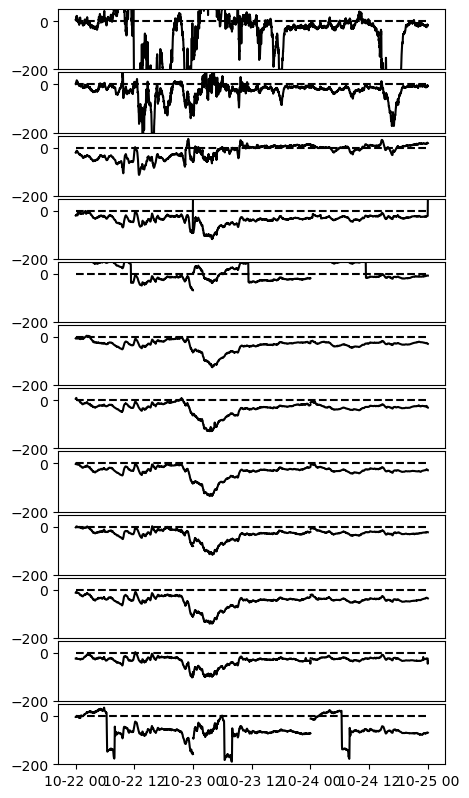

In [51]:
fig,ax = plt.subplots(12, 1, figsize=(5, 10), dpi=100, gridspec_kw=dict(hspace=0.05))
ax = ax.flatten()
for i in range(12):
    j = i
    d = rec[rec.station == lon_210[i]]
    x = d['datetime'].values
    ax[j].plot(x, d['X_d'], color='k')
    ax[j].hlines(0, x[0], x[-1], linestyles='dashed', color='k')
    
    ax[j].set_ylim(-200, 50)
    if j < 11:
        ax[j].set_xticks([])

plt.savefig(f'output/{short}_lon_210.png')
plt.show()

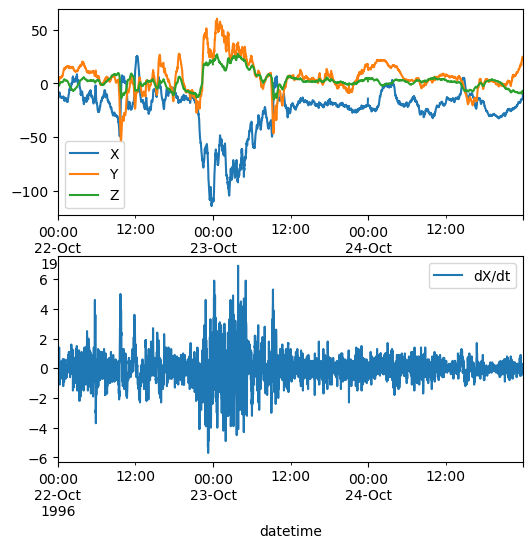

In [19]:
fig,ax = plt.subplots(2, 1, figsize=(6,6), dpi=100)
df.plot(x='datetime', y='X_d', ax=ax[0], label='X')
df.plot(x='datetime', y='Y_d', ax=ax[0], label='Y')
df.plot(x='datetime', y='Z_d', ax=ax[0], label='Z')

df.plot(x='datetime', y='dX', ax=ax[1], label='dX/dt')
#df.plot(x='datetime', y='dY', ax=ax[1], label='dY/dt')
#df.plot(x='datetime', y='dZ', ax=ax[1], label='dZ/dt')

plt.show()